## Import thư viện

In [12]:
import pyspark
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, count, when, to_timestamp, split, regexp_replace, row_number, sum, count_distinct
from functools import reduce
import pyspark.pandas as ps

## Khởi tạo Spark Session

In [13]:
spark = SparkSession.builder \
    .appName("Analysis") \
    .getOrCreate()

## Đọc file data

In [14]:
category_df = spark.read.csv("./data/preprocessed_data.csv", header=True, inferSchema=True)

In [15]:
category_df.show()

+---+-----------+-------------+--------------------+--------------------+---------------+-------------------+--------------------+--------+-------+--------+-------------+--------------------+
|_c0|   video_id|trending_date|               title|       channel_title|    category_id|       publish_time|                tags|   views|  likes|dislikes|comment_count|         description|
+---+-----------+-------------+--------------------+--------------------+---------------+-------------------+--------------------+--------+-------+--------+-------------+--------------------+
|  0|Jw1Y-zhQURU|   2017-11-14|John Lewis Christ...|          John Lewis|  Howto & Style|2017-11-10 07:38:29|"""christmas|""""...| 7224515|  55681|   10247|         9479|Click here to con...|
|  1|3s1rvMFUweQ|   2017-11-14|Taylor Swift: …Re...| Saturday Night Live|  Entertainment|2017-11-12 06:24:44|"""SNL|""""Saturd...| 1053632|  25561|    2294|         2757|Musical guest Tay...|
|  2|n1WpP7iowLc|   2017-11-14|Eminem - 

In [16]:
category_df.describe().show()

+-------+------------------+-----------+--------------------+--------------+----------------+--------------------+------------------+------------------+-----------------+-----------------+--------------------+
|summary|               _c0|   video_id|               title| channel_title|     category_id|                tags|             views|             likes|         dislikes|    comment_count|         description|
+-------+------------------+-----------+--------------------+--------------+----------------+--------------------+------------------+------------------+-----------------+-----------------+--------------------+
|  count|             38806|      38806|               38806|         38806|           38806|               38806|             38806|             38806|            38806|            38806|               38806|
|   mean|           19402.5|       NULL|                NULL|          NULL|            NULL|                NULL| 5918873.798613616| 134249.1777044787|7493.870

In [17]:
def dataframe_info(df):
    print(f"{'-'*40}")
    print(f"DataFrame thông tin:")
    print(f"Số dòng: {df.count()}")
    print(f"Số cột: {len(df.columns)}")
    print(f"{'-'*40}")
    print("Schema:")
    df.printSchema()
    print(f"{'-'*40}")
    print("Số giá trị null trong mỗi cột:")
    null_counts = df.select([
        count(when(col(c).isNull(), c)).alias(c) for c in df.columns
    ])
    null_counts.show()

In [18]:
dataframe_info(category_df)

----------------------------------------
DataFrame thông tin:
Số dòng: 38806
Số cột: 13
----------------------------------------
Schema:
root
 |-- _c0: integer (nullable = true)
 |-- video_id: string (nullable = true)
 |-- trending_date: date (nullable = true)
 |-- title: string (nullable = true)
 |-- channel_title: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- publish_time: timestamp (nullable = true)
 |-- tags: string (nullable = true)
 |-- views: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- description: string (nullable = true)

----------------------------------------
Số giá trị null trong mỗi cột:
+---+--------+-------------+-----+-------------+-----------+------------+----+-----+-----+--------+-------------+-----------+
|_c0|video_id|trending_date|title|channel_title|category_id|publish_time|tags|views|likes|dislikes|comment_count|description|


## Phân tích

### Số category

In [19]:
category_df.select('category_id').distinct().show()

+--------------------+
|         category_id|
+--------------------+
|           Education|
|              Gaming|
|       Entertainment|
|     Travel & Events|
|Science & Technology|
|              Sports|
|       Howto & Style|
|    Film & Animation|
|      People & Blogs|
|     News & Politics|
|      Pets & Animals|
|    Autos & Vehicles|
|               Music|
|              Comedy|
+--------------------+



In [20]:
category_df.select('category_id').distinct().count()

14

### Category nằm top trending nhiều nhất (1vid/ngày = 1 lần)

In [21]:
category_df.groupBy('category_id').count().orderBy("count", ascending=False).show()

+--------------------+-----+
|         category_id|count|
+--------------------+-----+
|               Music|13754|
|       Entertainment| 9124|
|      People & Blogs| 2926|
|    Film & Animation| 2577|
|       Howto & Style| 1928|
|              Sports| 1907|
|              Comedy| 1828|
|              Gaming| 1788|
|     News & Politics| 1225|
|      Pets & Animals|  534|
|Science & Technology|  518|
|           Education|  457|
|    Autos & Vehicles|  144|
|     Travel & Events|   96|
+--------------------+-----+



#### Chuyển thành pandas-on-Spark DataFrame và plot

<Axes: xlabel='category_id'>

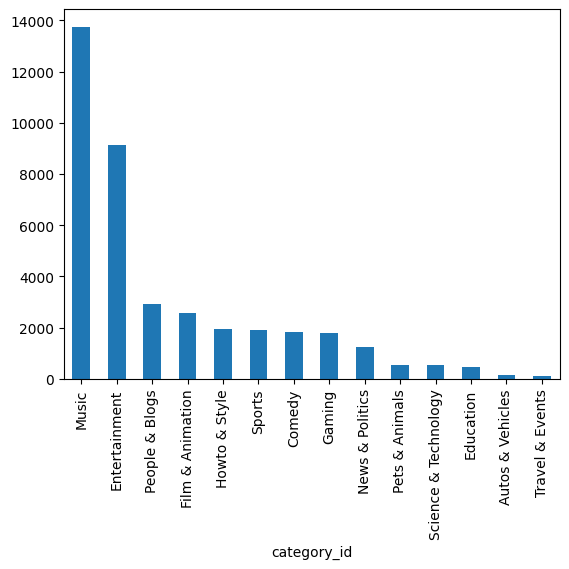

In [26]:
pandas_category_df = category_df.toPandas()
pandas_category_df['category_id'].value_counts().plot.bar()

### Category có tổng số lượng views cao nhất (Tổng số view (cao nhất) của các vid thuộc category cụ thể)

#### Tổng số vid

In [27]:
category_df.select('title').distinct().show()

+--------------------+
|               title|
+--------------------+
|Google Pixelbook:...|
|Fall Out Boy - HO...|
|The Poop In My Pa...|
|New Bon Iver song...|
|I Picked My Girlf...|
|New album Open He...|
|WWE fan interrupt...|
|ASOS UNBOXING HAU...|
|Let's talk... YOU...|
|Parenting Habits ...|
|Charles Manson  -...|
|New Christmas Dre...|
|[OFFICIAL VIDEO] ...|
|BEAK - (Merry Xma...|
|ORGANISING MY MUM...|
|Maroon 5 Busks in...|
|BTS interview at ...|
|Let's Talk Money ...|
|RUNNING OUT THE D...|
|I SNUCK INTO YOUT...|
+--------------------+
only showing top 20 rows



In [28]:
category_df.select('title').distinct().count()

3363

#### Lọc lấy số view cao nhất của từng vid

In [29]:
windowSpec = Window.partitionBy("title").orderBy(col("views").desc())
windowSpec

In [30]:
view_df = category_df.withColumn("view_rank", row_number().over(windowSpec))
view_df.show()

+-----+-----------+-------------+--------------------+-----------------+--------------+-------------------+--------------------+------+-----+--------+-------------+--------------------+---------+
|  _c0|   video_id|trending_date|               title|    channel_title|   category_id|       publish_time|                tags| views|likes|dislikes|comment_count|         description|view_rank|
+-----+-----------+-------------+--------------------+-----------------+--------------+-------------------+--------------------+------+-----+--------+-------------+--------------------+---------+
|  567|NLCfRHdi6Ig|   2017-11-16|#21 How to go FAS...|       Ben Cathro|        Sports|2017-11-05 20:10:16|"""Ben Cathro|"""...| 16074|  689|       8|          142|How flipping rad ...|        1|
|  358|NLCfRHdi6Ig|   2017-11-15|#21 How to go FAS...|       Ben Cathro|        Sports|2017-11-05 20:10:16|"""Ben Cathro|"""...| 15818|  686|       8|          141|How flipping rad ...|        2|
|  146|NLCfRHdi6Ig| 

In [31]:
view_df = view_df.filter(col('view_rank') == 1)
view_df.show()

+-----+-----------+-------------+--------------------+--------------------+----------------+-------------------+--------------------+--------+------+--------+-------------+--------------------+---------+
|  _c0|   video_id|trending_date|               title|       channel_title|     category_id|       publish_time|                tags|   views| likes|dislikes|comment_count|         description|view_rank|
+-----+-----------+-------------+--------------------+--------------------+----------------+-------------------+--------------------+--------+------+--------+-------------+--------------------+---------+
|  567|NLCfRHdi6Ig|   2017-11-16|#21 How to go FAS...|          Ben Cathro|          Sports|2017-11-05 20:10:16|"""Ben Cathro|"""...|   16074|   689|       8|          142|How flipping rad ...|        1|
| 1791|1cgK-BIrXes|   2017-11-22|#VeteransDay: Tha...|   YouTube Spotlight|   Entertainment|2017-11-10 15:07:13|"""vets|""""veter...|  916104| 27405|    2153|         5292|This #Vetera

#### Tính tổng số view theo category

In [32]:
total_view_df = view_df.groupBy('category_id').agg(sum('views').alias('total_views')).orderBy("total_views", ascending=False)
total_view_df = total_view_df.withColumn("total_views", col("total_views").cast("long"))
total_view_df.show()

+--------------------+-----------+
|         category_id|total_views|
+--------------------+-----------+
|               Music|11638088588|
|       Entertainment| 2261526855|
|    Film & Animation|  489044774|
|              Comedy|  416205730|
|      People & Blogs|  362990502|
|              Sports|  230310607|
|              Gaming|  143244559|
|     News & Politics|   99064864|
|       Howto & Style|   91930783|
|Science & Technology|   85714412|
|      Pets & Animals|   37028580|
|           Education|   29669336|
|    Autos & Vehicles|   20406847|
|     Travel & Events|   10717623|
+--------------------+-----------+



#### Chuyển thành pandas-on-Spark DataFrame và plot

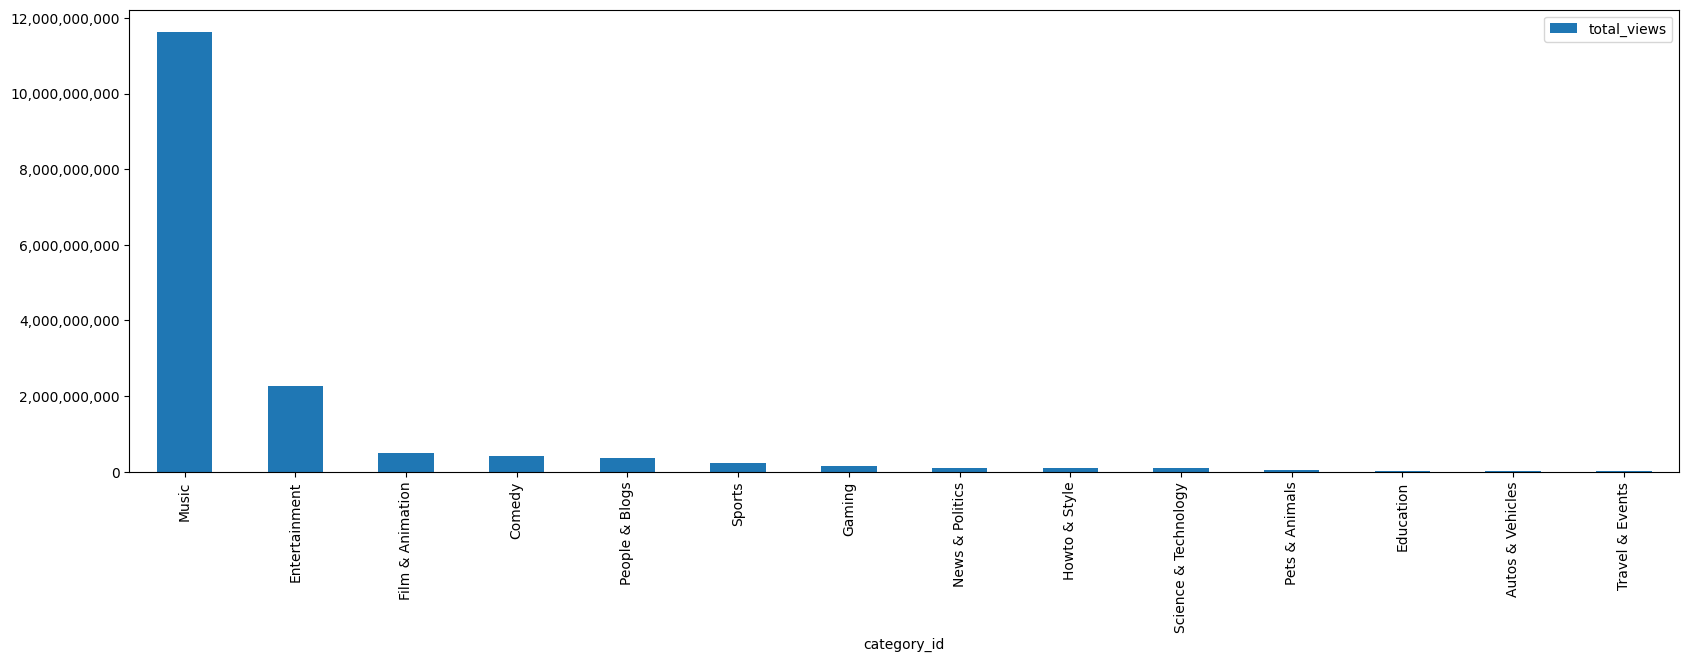

In [ ]:
pandas_total_view_df = total_view_df.toPandas()
pandas_without_music = pandas_total_view_df[pandas_total_view_df['category_id'] != 'Music']
import matplotlib.ticker as mtick

ax = pandas_total_view_df.plot.bar(x='category_id', y='total_views', figsize=(20, 6))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}'))

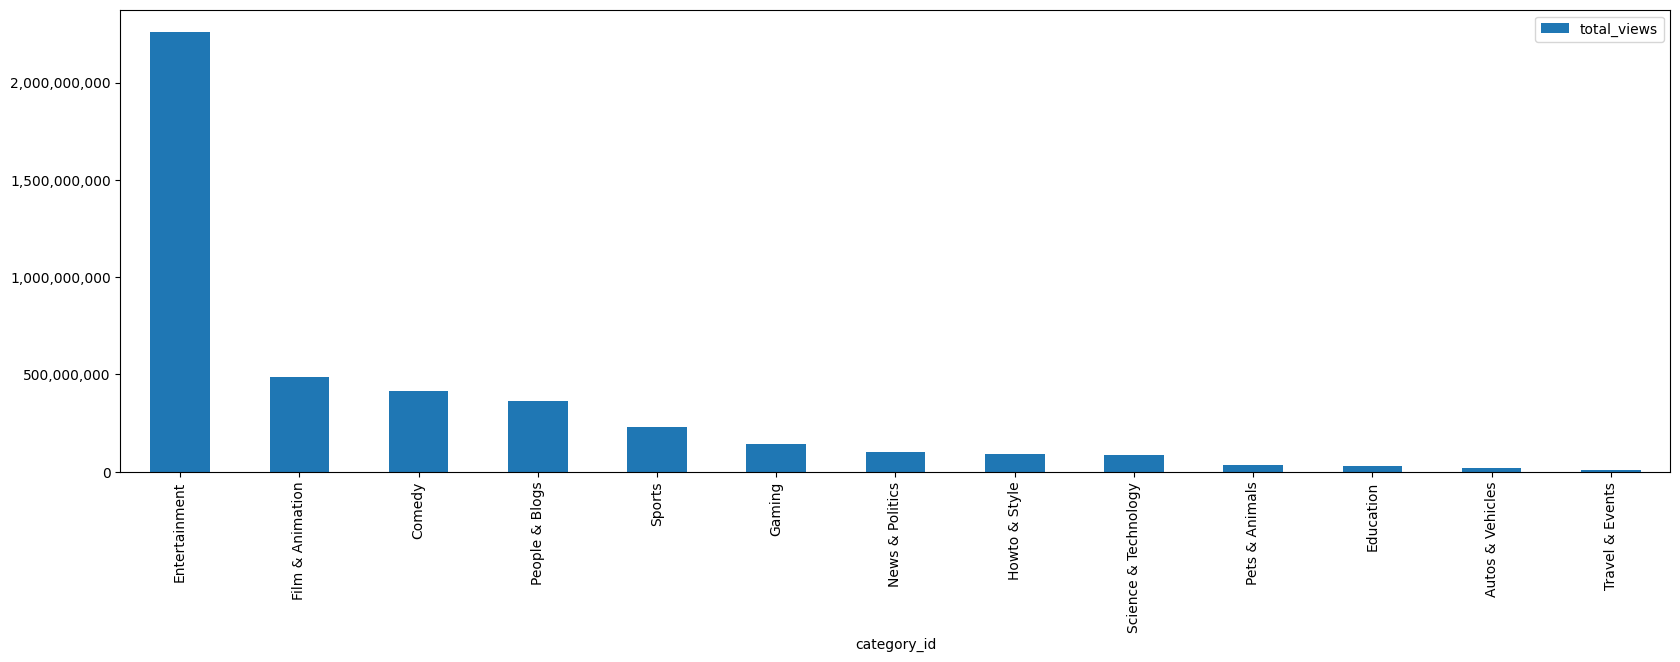

In [ ]:
# Music is too significant => Plot again to see the remaining differences.
ax = pandas_without_music.plot.bar(x='category_id', y='total_views', figsize=(20, 6))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}'))  # Format as comma-separated numbers

### Category có nhiều kênh youtube làm nhất

In [35]:
channel_df = category_df.groupBy('category_id').agg(count_distinct('channel_title').alias('total_channels')).orderBy("total_channels", ascending=False)
channel_df.show()

+--------------------+--------------+
|         category_id|total_channels|
+--------------------+--------------+
|               Music|           505|
|       Entertainment|           339|
|      People & Blogs|           188|
|              Gaming|           124|
|    Film & Animation|           103|
|              Sports|            92|
|       Howto & Style|            82|
|              Comedy|            75|
|     News & Politics|            61|
|Science & Technology|            34|
|           Education|            31|
|      Pets & Animals|            25|
|    Autos & Vehicles|            14|
|     Travel & Events|             9|
+--------------------+--------------+



#### Chuyển thành pandas-on-Spark DataFrame và plot

<Axes: xlabel='category_id'>

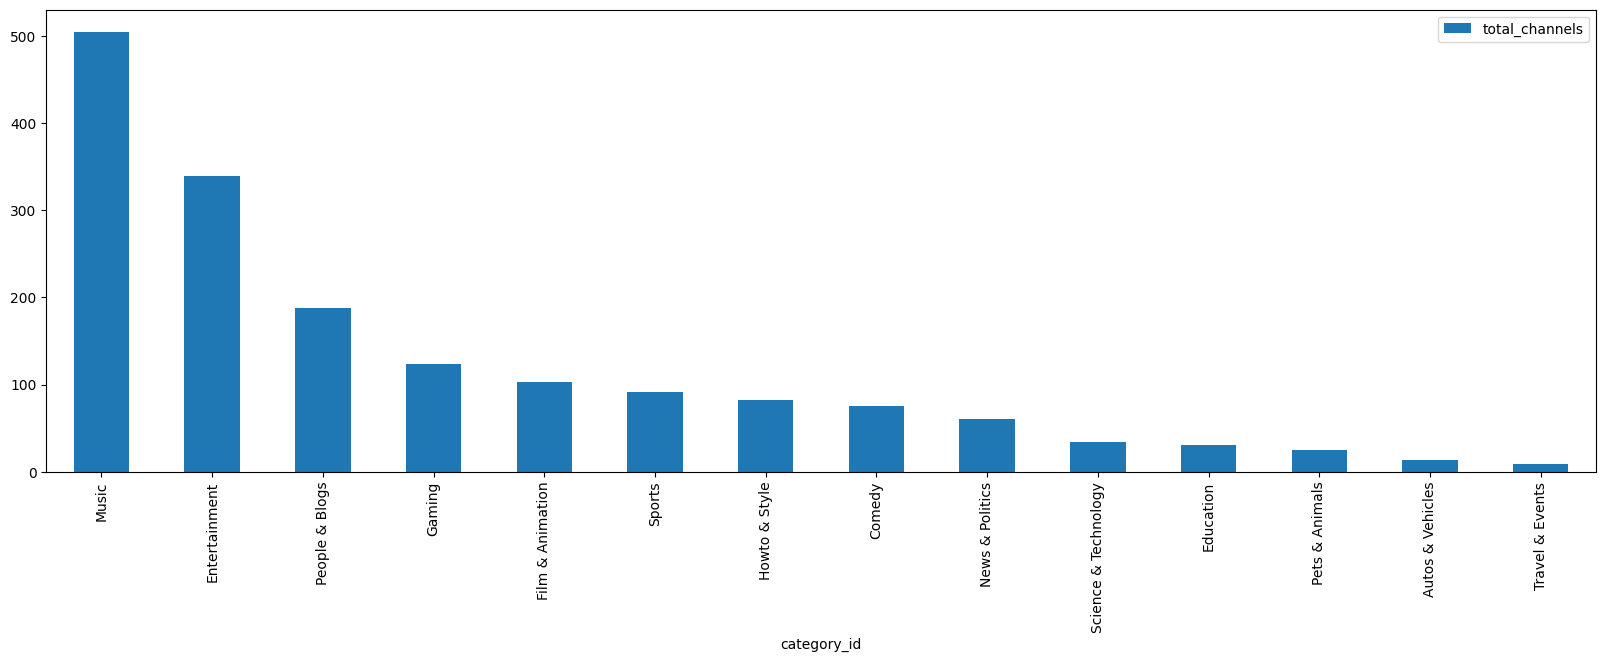

In [40]:
pandas_channel_df = channel_df.toPandas()
pandas_channel_df.plot.bar(x='category_id', y='total_channels', figsize=(20, 6))